In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from torch.optim import Adam
import matplotlib.pyplot as plt


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
datafolder = '.'
train_dataset = datasets.CIFAR10(root=datafolder, train=True,  download=True, transform=transforms.ToTensor())
test_dataset  = datasets.CIFAR10(root=datafolder, train=False, download=True, transform=transforms.ToTensor())

train_dataloader = DataLoader(train_dataset, 512,  True)
test_dataloader  = DataLoader(test_dataset,  512, False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
example = iter(train_dataloader)
data, target = example.__next__()
print(data.shape)
print(target.shape)

torch.Size([512, 3, 32, 32])
torch.Size([512])


In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, num_patches=4, embed_dim=768):
        super(PositionalEmbedding, self).__init__()
        self.pose_embed = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim))

    def forward(self, x):
        return self.pose_embed + x

In [ ]:
class Patchify(nn.Module):
    def __init__(self, patch_size=16, in_channels=3, embed_dim=768):
        super(Patchify, self).__init__()
        self.conv = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class Unpatchify(nn.Module):
    def __init__(self, patch_size=16, in_channels=3, embed_dim=768, image_size=32):
        super(Unpatchify, self).__init__()
        self.image_size = image_size
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.deconv = nn.ConvTranspose2d(embed_dim, in_channels, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = x.transpose(1, 2)
        batch_size, embed_dim, num_patches = x.shape
        h = w = int(num_patches ** 0.5)
        x = x.reshape(batch_size, embed_dim, h, w)
        x = self.deconv(x)
        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, d_model=768, patch_size=16, in_channels=3):
        super(Encoder, self).__init__()

        self.d_model = d_model

        self.patches = Patchify()

        self.PositionalEmbedding = PositionalEmbedding()

        transform_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, batch_first=True)
        self.transform_encoder = nn.TransformerEncoder(encoder_layer=transform_layer, num_layers=4)

    def forward(self, x):
        x = self.patches(x)
        batch_size, num_patches, _ = x.size()
        shuffle_indices = torch.randperm(num_patches, device=x.device)
        x = x[:, shuffle_indices, :]
        cls_token = nn.Parameter(torch.zeros(x.size(0), 1, self.d_model)).to(x.device)
        x = torch.cat((x, cls_token), dim=1)
        x = self.PositionalEmbedding(x)
        x = self.transform_encoder(x)
        return x, shuffle_indices

class Decoder(nn.Module):
    def __init__(self, d_model=768, patch_size=16, image_size=32):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.unpatches = Unpatchify(patch_size=patch_size, image_size=image_size)
        transform_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, batch_first=True)
        self.transform_decoder = nn.TransformerDecoder(decoder_layer=transform_layer, num_layers=6)

    def forward(self, x, shuffle_indices):
        cls_tokens = x[:, 0:1, :]  # Extract the cls_token
        x = x[:, 1:, :]  # Remove the cls_token
        x = self.transform_decoder(x, cls_tokens)
        unshuffle_indices = torch.argsort(shuffle_indices)
        x = x[:, unshuffle_indices, :]
        x = self.unpatches(x)
        return x


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, d_model=768, num_classes=10):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(d_model=d_model)
        self.decoder = Decoder(d_model=d_model)
        self.cls_head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        encoded, shuffle_indices = self.encoder(x)
        decoded = self.decoder(encoded, shuffle_indices)
        cls_token = encoded[:, 0]  # Use the output of the CLS token for classification
        classification_output = self.cls_head(cls_token)
        return classification_output, decoded
        # return decoded

In [ ]:
model = AutoEncoder().to(device=device)
classification_criterion = nn.CrossEntropyLoss()
reconstruction_criterion = nn.MSELoss()
optim = Adam(model.parameters(), lr=0.001)

Epoch 0, Batch 0: Loss 0.6257486939430237
Epoch 0: Test Loss 0.08377397134900093


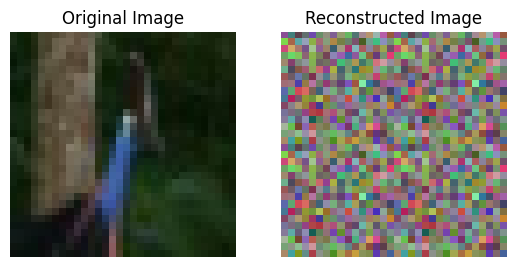

Epoch 0, Batch 10: Loss 0.08460446447134018
Epoch 0: Test Loss 0.06920582912862301


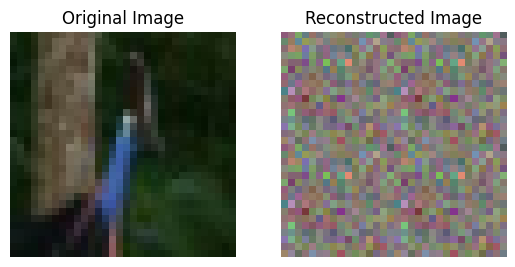

Epoch 0, Batch 20: Loss 0.0687103122472763
Epoch 0: Test Loss 0.06514223255217075


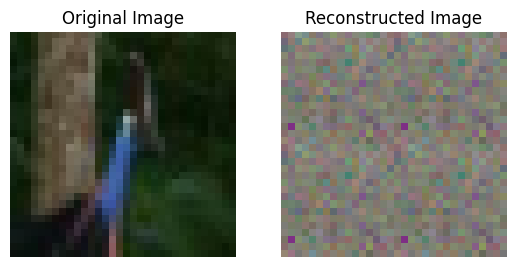

Epoch 0, Batch 30: Loss 0.06618732959032059
Epoch 0: Test Loss 0.0638444684445858


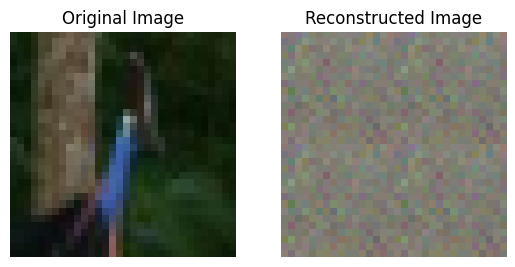

Epoch 0, Batch 40: Loss 0.0645570307970047
Epoch 0: Test Loss 0.06335778217762708


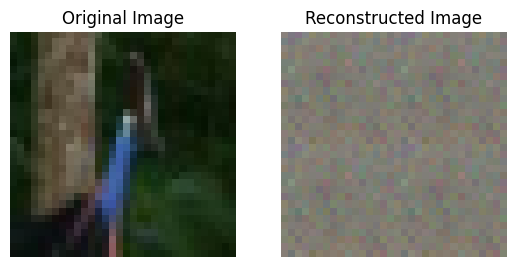

Epoch 0, Batch 50: Loss 0.06341893970966339
Epoch 0: Test Loss 0.06364589110016823


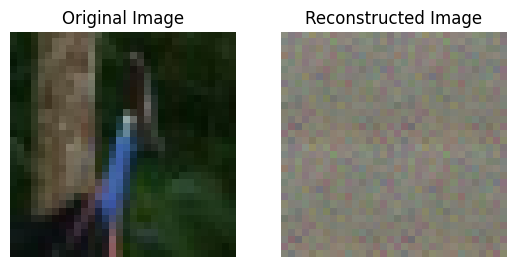

Epoch 0, Batch 60: Loss 0.06202886626124382
Epoch 0: Test Loss 0.06290868129581213


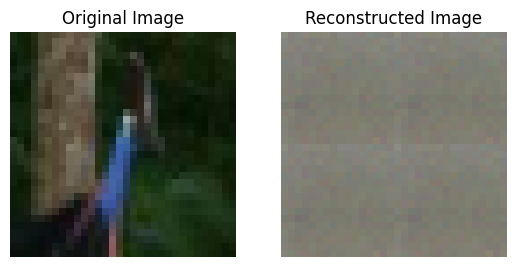

Epoch 0, Batch 70: Loss 0.06197614595293999
Epoch 0: Test Loss 0.0629020044580102


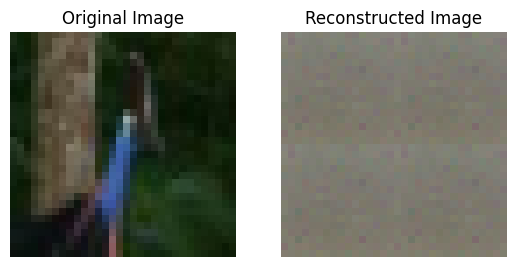

Epoch 0, Batch 80: Loss 0.06618782877922058
Epoch 0: Test Loss 0.06286274325102567


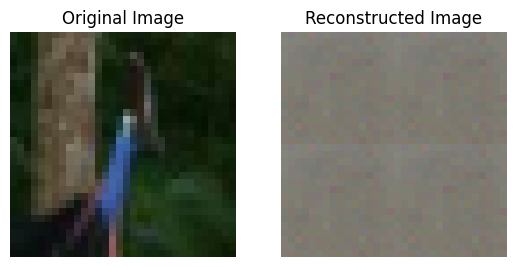

Epoch 0, Batch 90: Loss 0.0647900328040123
Epoch 1, Batch 0: Loss 0.08959778398275375
Epoch 1: Test Loss 0.06390476301312446


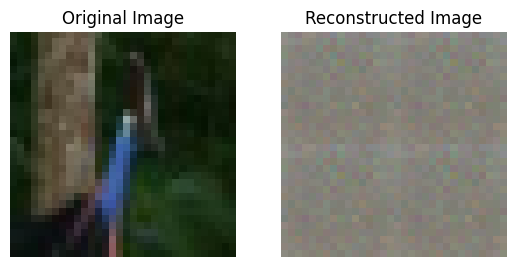

Epoch 1, Batch 10: Loss 0.06727765500545502
Epoch 1: Test Loss 0.06374949365854263


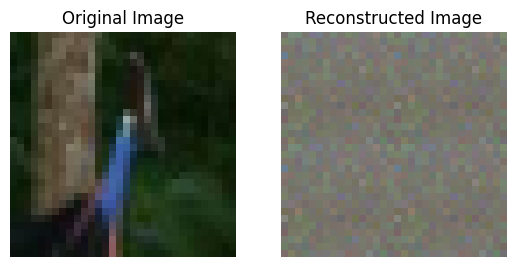

Epoch 1, Batch 20: Loss 0.06399562954902649
Epoch 1: Test Loss 0.0631404159590602


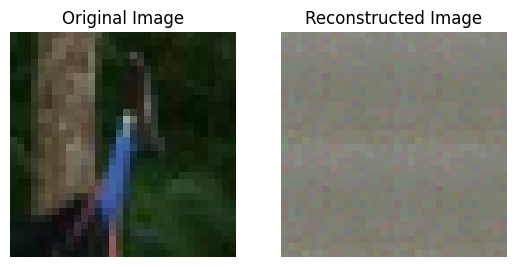

Epoch 1, Batch 30: Loss 0.06466582417488098
Epoch 1: Test Loss 0.06340659111738205


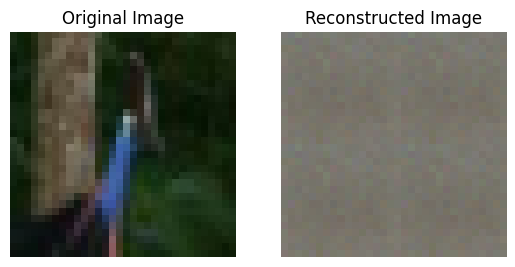

Epoch 1, Batch 40: Loss 0.06200356408953667


KeyboardInterrupt: 

In [ ]:
# Training loop
for epoch in range(3):
    model.train()
    for index, (img, label) in enumerate(train_dataloader):
        img, label = img.to(device), label.to(device)
        optim.zero_grad()  # Reset gradients
        classification_output, reconstructed_img = model(img)
        classification_loss = classification_criterion(classification_output, label)
        # reconstructed_img = model(img)
        reconstruction_loss = reconstruction_criterion(reconstructed_img, img)
        loss = reconstruction_loss + classification_output
        loss.backward()
        optim.step()
        if index % 10 == 0:
            print(f'Epoch {epoch}, Batch {index}: Loss {loss.item()}')
        if (index+1) % 10 == 0:
            test_loss = 0.0
            model.eval()
            with torch.no_grad():
                for img, label in test_dataloader:
                    img, label = img.to(device), label.to(device)
                    reconstructed_img = model(img)
                    reconstruction_loss = reconstruction_criterion(reconstructed_img, img)
                    loss = reconstruction_loss
                    test_loss += loss.item()

                test_loss /= len(test_dataloader)
                print(f'Epoch {epoch}: Test Loss {test_loss}')
                # Visualize the first original and reconstructed image in the test set
                original_img = img[0].cpu().permute(1, 2, 0).detach().numpy()
                reconstructed_img = reconstructed_img[0].cpu().permute(1, 2, 0).detach().numpy()

                # Plot original and reconstructed images side by side
                fig, axes = plt.subplots(1, 2)
                axes[0].imshow(original_img)
                axes[0].set_title("Original Image")
                axes[0].axis('off')

                axes[1].imshow(reconstructed_img)
                axes[1].set_title("Reconstructed Image")
                axes[1].axis('off')

                plt.show()




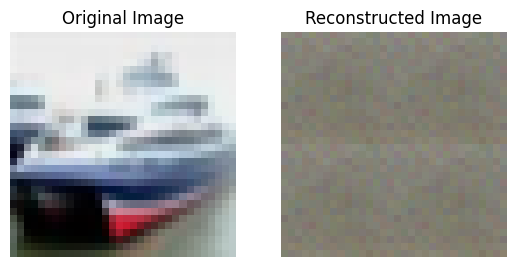

In [ ]:
reconstructed_img = None
img = None
# Example testing loop
model.eval()
with torch.no_grad():
    for index, (img, label) in enumerate(test_dataloader):
        img, label = img.to(device), label.to(device)
        # classification_output, reconstructed_img = model(img)
        reconstructed_img = model(img)

        # Visualize the first original and reconstructed image in the batch
        original_img = img[1].cpu().permute(1, 2, 0).detach().numpy()
        reconstructed_img = reconstructed_img[1].cpu().permute(1, 2, 0).detach().numpy()

        # Plot original and reconstructed images side by side
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(original_img)
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(reconstructed_img)
        axes[1].set_title("Reconstructed Image")
        axes[1].axis('off')

        plt.show()
        break  # Just run one batch for example